### This Notebook serves as a tutorial for 2 purposes with Apache Spark
1. It provides an analysis of the Movie Lens Dataset(It shows how the Aggregation methods are simple but very effective)
2. Recommendation engine based on Collabrative filtering (ALS from MLlib)

Some of the Links and references I have used are -
1. Dataset can be found [here](https://grouplens.org/datasets/movielens/20m/) or at [kaggle](https://www.kaggle.com/grouplens/movielens-20m-dataset)
2. edX Apache Spark course cs110 Assignment 2 (Movie Recommendation) I have used my own code from that notebook (Not providing my notebook link here just in case course is offered again with same Assignments) Side note -  It is one of the best and the most intense course series I have ever done.
3. A More Scalable Way of Making Recommendations with MLlib - Xiangrui Meng [here](https://www.youtube.com/watch?v=Q0VXllYilM0&)
4. I have used [Databricks community edition cloud](https://community.cloud.databricks.com). This is because we already have the required dataset mounted on the Cloud. Also, Databricks community edition has tons of features (I love the display feature) and the whole system is preconfigured.One important thing here (Also, a differentiating feature) is we do not need to create spark context or sql context object which is already created for us

A caution Note- 
We won't do collect() here as that will push all the data back to the Driver which might cause out of memory error. 

In [0]:
#We already have sc and sqlContext for us here
print (sc)
print (sqlContext)
import os

<SparkContext master=local[8] appName=Databricks Shell>


### Getting the data
It is already mounted for us

In [0]:
# Assuming Spark 2.x and above with SparkSession available as 'spark'

# Read the ratings file
ratings_df = spark.read.csv('/databricks-datasets/cs110x/ml-20m/data-001/ratings.csv', header=True, inferSchema=True)

# Read the movies file
movies_df = spark.read.csv('/databricks-datasets/cs110x/ml-20m/data-001/movies.csv', header=True, inferSchema=True)

# Show the first few rows of the DataFrames to verify
ratings_df.show(5)
movies_df.show(5)


+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      2|   3.5|1112486027|
|     1|     29|   3.5|1112484676|
|     1|     32|   3.5|1112484819|
|     1|     47|   3.5|1112484727|
|     1|     50|   3.5|1112484580|
|     1|    112|   3.5|1094785740|
|     1|    151|   4.0|1094785734|
|     1|    223|   4.0|1112485573|
|     1|    253|   4.0|1112484940|
|     1|    260|   4.0|1112484826|
|     1|    293|   4.0|1112484703|
|     1|    296|   4.0|1112484767|
|     1|    318|   4.0|1112484798|
|     1|    337|   3.5|1094785709|
|     1|    367|   3.5|1112485980|
|     1|    541|   4.0|1112484603|
|     1|    589|   3.5|1112485557|
|     1|    593|   3.5|1112484661|
|     1|    653|   3.0|1094785691|
|     1|    919|   3.5|1094785621|
+------+-------+------+----------+
only showing top 20 rows

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+

#### Data Exploration

In [0]:
# Display the schema of the DataFrames
ratings_df.printSchema()
movies_df.printSchema()

# Show the first few rows to understand the data
ratings_df.show(5)
movies_df.show(5)

# Basic statistics for numerical columns
ratings_df.describe().show()

# Count the number of distinct movies and users
num_movies = movies_df.select("movieId").distinct().count()
num_users = ratings_df.select("userId").distinct().count()
print(f"Number of movies: {num_movies}, Number of users: {num_users}")

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      2|   3.5|1112486027|
|     1|     29|   3.5|1112484676|
|     1|     32|   3.5|1112484819|
|     1|     47|   3.5|1112484727|
|     1|     50|   3.5|1112484580|
+------+-------+------+----------+
only showing top 5 rows

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|F

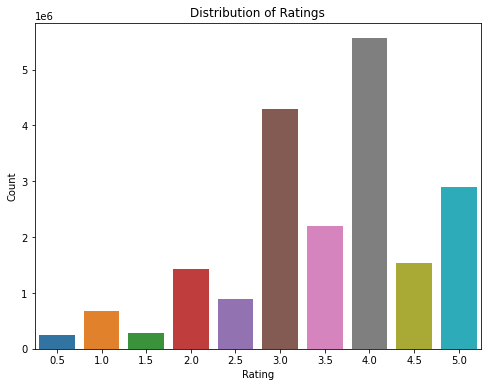

+-------+-----+
|movieId|count|
+-------+-----+
|    296|67310|
|    356|66172|
|    318|63366|
|    593|63299|
|    480|59715|
|    260|54502|
|    110|53769|
|    589|52244|
|   2571|51334|
|    527|50054|
|      1|49695|
|    457|49581|
|    150|47777|
|    780|47048|
|     50|47006|
|   1210|46839|
|    592|46054|
|   1196|45313|
|   2858|44987|
|     32|44980|
+-------+-----+
only showing top 20 rows

+------+-----+
|userId|count|
+------+-----+
|118205| 9254|
|  8405| 7515|
| 82418| 5646|
|121535| 5520|
|125794| 5491|
| 74142| 5447|
| 34576| 5356|
|131904| 5330|
| 83090| 5169|
| 59477| 4988|
|130767| 4785|
| 79159| 4707|
|  8963| 4524|
| 15617| 4354|
| 92011| 4236|
| 71975| 4182|
| 20132| 4101|
| 46470| 4094|
| 88820| 4093|
| 63147| 3958|
+------+-----+
only showing top 20 rows



In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert ratings DataFrame to Pandas for visualization
ratings_pd = ratings_df.toPandas()

# Plotting the distribution of ratings
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=ratings_pd)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Number of ratings per movie
ratings_per_movie = ratings_df.groupBy('movieId').count().orderBy('count', ascending=False)
ratings_per_movie.show()

# Number of ratings per user
ratings_per_user = ratings_df.groupBy('userId').count().orderBy('count', ascending=False)
ratings_per_user.show()

In [0]:
from pyspark.sql.functions import avg

# Join the ratings and movies DataFrames on the movieId column
movie_ratings_df = ratings_df.join(movies_df, 'movieId')

from pyspark.sql.functions import explode, split

# Split the genres string into a list and then explode the list into separate rows
movie_ratings_df = movie_ratings_df.withColumn("genre", explode(split("genres", "\|")))

# Group by genre and calculate the average rating
genre_ratings = movie_ratings_df.groupBy('genre').agg(avg('rating').alias('avg_rating'))
genre_ratings.show()

+------------------+------------------+
|             genre|        avg_rating|
+------------------+------------------+
|             Crime|3.6745276025631113|
|           Romance| 3.541802581902903|
|          Thriller|  3.50711121809216|
|         Adventure|3.5018926565473865|
|             Drama|3.6742955093068264|
|               War|3.8095307347384844|
|       Documentary|3.7397176834178865|
|           Fantasy|3.5059453358738244|
|           Mystery| 3.663508921312903|
|           Musical| 3.558090628821412|
|         Animation|3.6174939235897994|
|         Film-Noir|  3.96538126070082|
|(no genres listed)|3.0069252077562325|
|              IMAX| 3.655945983272606|
|            Horror|3.2772238097518307|
|           Western|3.5704980246109406|
|            Comedy|3.4260113054324886|
|          Children|3.4081137685270444|
|            Action|  3.44386376493354|
|            Sci-Fi|3.4367726714455005|
+------------------+------------------+



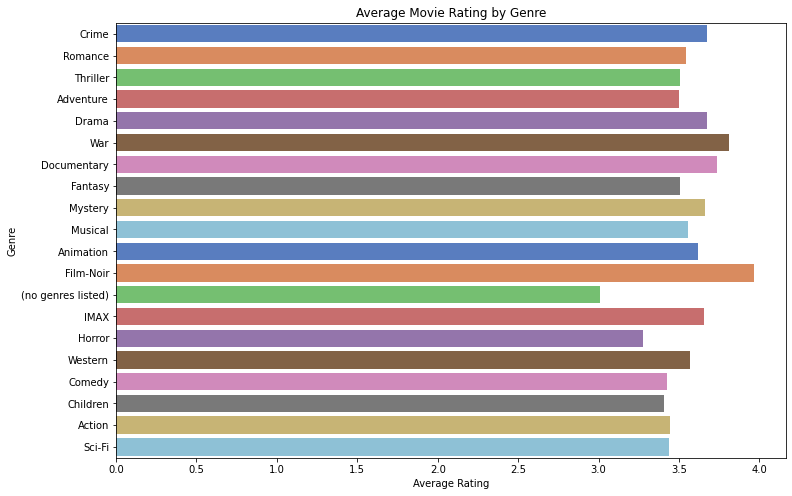

In [0]:
# Convert the Spark DataFrame to a Pandas DataFrame
genre_ratings_pd = genre_ratings.toPandas()

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='avg_rating', y='genre', data=genre_ratings_pd, ci=None, palette='muted', orient='h')
plt.title('Average Movie Rating by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.show()

#### Data Preparation Enhancements

In [0]:
from pyspark.sql.functions import col

# Assuming 'ratings_df' is your initial DataFrame and you want to create 'ratings_df_final' without the timestamp column
ratings_df_final = ratings_df.select(
    col("userId").cast("integer"),
    col("movieId").cast("integer"),
    col("rating").cast("double")
)

# Now, 'ratings_df_final' is a DataFrame and you can use the show() method
ratings_df_final.show(4)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      2|   3.5|
|     1|     29|   3.5|
|     1|     32|   3.5|
|     1|     47|   3.5|
+------+-------+------+
only showing top 4 rows



In [0]:
from pyspark.sql.functions import col

# Filtering out movies with fewer than 10 ratings
movies_with_ratings = ratings_df.groupBy('movieId').count().filter("`count` >= 800").withColumnRenamed("count", "movie_count")
ratings_df_filtered = ratings_df.join(movies_with_ratings, 'movieId').filter("movie_count >= 800")

# Similarly, filtering out users with fewer than 10 ratings
users_with_ratings = ratings_df_filtered.groupBy('userId').count().filter("`count` >= 25").withColumnRenamed("count", "user_count")
ratings_df_final = ratings_df_filtered.join(users_with_ratings, 'userId').filter("user_count >= 25").select(ratings_df_filtered["userId"], "movieId", "rating")


In [0]:
ratings_df_final.show(5)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|   471|   1088|   2.0|
|   471|   1580|   3.0|
|   471|   1645|   3.0|
|   471|   1959|   4.0|
|   471|   2866|   4.0|
+------+-------+------+
only showing top 5 rows



#### Data Preparation

In [0]:
# Check for missing values in the DataFrames
for column in ratings_df_final.columns:
    missing_count = ratings_df_final.filter(ratings_df_final[column].isNull()).count()
    if missing_count > 0:
        print(f"Column {column} has {missing_count} missing values")

In [0]:
# Split the final DataFrame into training and test sets
(training_data, test_data) = ratings_df_final.randomSplit([0.8, 0.2], seed=1234)

# Display the count of rows in each dataset to verify the split
print(f"Training Data Count: {training_data.count()}")
print(f"Test Data Count: {test_data.count()}")

Training Data Count: 14200523
Test Data Count: 3548564


#### Modeling

In [0]:
from pyspark.ml.recommendation import ALS

# Enhanced ALS model initialization with additional parameters
als_enhanced = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", nonnegative=True, implicitPrefs=False, coldStartStrategy="drop", maxIter=4, regParam=0.1)

# Fit the enhanced model to the training data
model_enhanced = als_enhanced.fit(training_data)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/databricks/python/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<command-3572662605254387>", line 16, in <module>
    rmse = evaluator.evaluate(predictions)
NameError: name 'predictions' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/databricks/python/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 1997, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/databricks/python/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1112, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/databricks/python/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1006, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/databricks/python/lib/python3.9/site-packages/IPy

In [0]:
# Generate predictions on the test data with the enhanced model
predictions_enhanced = model_enhanced.transform(test_data)

# Evaluate the enhanced model using RMSE
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions_enhanced)
print(f"Enhanced model - Root-mean-square error = {rmse}")

Enhanced model - Root-mean-square error = 0.8279425248318577


#### Recommendation 

In [0]:
from pyspark.sql import Row
my_user_id = 0

# Note that the movie IDs are the *last* number on each line. A common error was to use the number of ratings as the movie ID.
my_rated_movies = [
     (0,1193,4.4),(0,2959,4.0),(0,356,5.0),(0,858,2.0)
     # The format of each line is (my_user_id, movie ID, your rating)
     ]

my_ratings_df = sqlContext.createDataFrame(my_rated_movies, ['userId','movieId','rating'])
print ('My movie ratings:')
my_ratings_df.show()

My movie ratings:
+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     0|   1193|   4.4|
|     0|   2959|   4.0|
|     0|    356|   5.0|
|     0|    858|   2.0|
+------+-------+------+



In [0]:
# Now adding my_ratings to the training_df
training_with_my_ratings_df = training_data.unionAll(my_ratings_df)
print("the train data has %s more entries now" % (training_with_my_ratings_df.count() - training_data.count()))

the train data has 4 more entries now


In [0]:
# Enhanced ALS model initialization with additional parameters
als_enhanced = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", nonnegative=True, implicitPrefs=False, coldStartStrategy="drop", maxIter=4, regParam=0.1)

# Fit the enhanced model to the training data
model_my_ratings = als_enhanced.fit(training_with_my_ratings_df)

# Generate predictions on the test data with the enhanced model
predictions_my_ratings = model_my_ratings.transform(test_data)

# Evaluate the model with my ratings using RMSE

rmse = evaluator.evaluate(predictions_my_ratings)
print(f"Enhanced model - Root-mean-square error = {rmse}")

Enhanced model - Root-mean-square error = 0.8238741532709573


In [0]:
from pyspark.sql import functions as F

# Create a list of my rated movie IDs
my_rated_movie_ids = [x[1] for x in my_rated_movies]

# Filter out the movies I already rated.'~' sign will make sure not to include them.
not_rated_df = movies_df.filter(~ movies_df['movieId'].isin(my_rated_movie_ids))

# Rename the "ID" column to be "movieId", and add a column with my_user_id as "userId".
my_unrated_movies_df = not_rated_df.withColumnRenamed('movieId','movieId').withColumn('userId',F.lit(0))

# Use my_rating_model to predict ratings for the movies that I did not manually rate.
predicted_ratings_df = model_my_ratings.transform(my_unrated_movies_df)

#### Finding the best suited movie


In [0]:
#some sample ratings
predicted_ratings_df.show(4,truncate = False)

+-------+------------------------+-------------------------------------------+------+----------+
|movieId|title                   |genres                                     |userId|prediction|
+-------+------------------------+-------------------------------------------+------+----------+
|1      |Toy Story (1995)        |Adventure|Animation|Children|Comedy|Fantasy|0     |3.6149206 |
|2      |Jumanji (1995)          |Adventure|Children|Fantasy                 |0     |3.5634315 |
|3      |Grumpier Old Men (1995) |Comedy|Romance                             |0     |3.2482367 |
|4      |Waiting to Exhale (1995)|Comedy|Drama|Romance                       |0     |2.9475908 |
+-------+------------------------+-------------------------------------------+------+----------+
only showing top 4 rows



#### Recommendation for a Specific User

In [0]:
from pyspark.sql.functions import lit

userId = 1

# Create a DataFrame with a single row and the specified user ID
user_df = spark.createDataFrame([(userId,)], ["userId"])

# Make recommendations for the user subset
user_recommendations = model_enhanced.recommendForUserSubset(user_df, 10)

# Show the recommendations
user_recommendations.show()


+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     1|[{318, 4.2291145}...|
+------+--------------------+



In [0]:
from pyspark.sql.functions import explode

# Explode the recommendations array
user_recommendations_exploded = user_recommendations.select("userId", explode("recommendations").alias("recommendation"))

# Extract fields from the struct
user_recommendations_formatted = user_recommendations_exploded.select("userId", "recommendation.movieId", "recommendation.rating")

# Show the formatted recommendations
user_recommendations_formatted.show()


+------+-------+---------+
|userId|movieId|   rating|
+------+-------+---------+
|     1|    318|4.2291145|
|     1|   7153|4.1150975|
|     1|     50|4.0999894|
|     1|    260|4.0997667|
|     1|   4993|4.0970488|
|     1|   2571|4.0956964|
|     1|   1196|4.0833473|
|     1|   1198| 4.082751|
|     1|   5952|4.0814753|
|     1|  58559| 4.007797|
+------+-------+---------+



## 2. Item-Based Recommendation 

In [0]:
# Read the ratings file
ratings_df = spark.read.csv('/databricks-datasets/cs110x/ml-20m/data-001/ratings.csv', header=True, inferSchema=True)

# Read the movies file
movies_df = spark.read.csv('/databricks-datasets/cs110x/ml-20m/data-001/movies.csv', header=True, inferSchema=True)

# Show the first few rows of the DataFrames to verify
ratings_df.show(5)
movies_df.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      2|   3.5|1112486027|
|     1|     29|   3.5|1112484676|
|     1|     32|   3.5|1112484819|
|     1|     47|   3.5|1112484727|
|     1|     50|   3.5|1112484580|
+------+-------+------+----------+
only showing top 5 rows

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [0]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.types import ArrayType, DoubleType

# Define a UDF to extract vector elements
def extract_vector_elements(vec):
    return vec.toArray().tolist()

extract_vector_elements_udf = udf(extract_vector_elements, ArrayType(DoubleType()))

# Apply the UDF to create a column for each genre
vectorized_df = vectorized_df.withColumn("genre_array", extract_vector_elements_udf("genre_vec"))

# Explode genre_array into separate columns
for i in range(len(model.vocabulary)):
    vectorized_df = vectorized_df.withColumn(f"genre_{i}", vectorized_df["genre_array"][i])


In [0]:
from pyspark.sql.functions import avg
from pyspark.sql.functions import explode, split

# Join the ratings and movies DataFrames on the movieId column
movie_ratings_df = ratings_df.join(movies_df, 'movieId')

# Split the genres string into a list and then explode the list into separate rows
movie_ratings_df = movie_ratings_df.withColumn("genre", explode(split("genres", "\|")))
movie_ratings_df = movie_ratings_df.drop('genres')
movie_ratings_df.show(4)

+-------+------+------+----------+--------------------+---------+
|movieId|userId|rating| timestamp|               title|    genre|
+-------+------+------+----------+--------------------+---------+
|      2|     1|   3.5|1112486027|      Jumanji (1995)|Adventure|
|      2|     1|   3.5|1112486027|      Jumanji (1995)| Children|
|      2|     1|   3.5|1112486027|      Jumanji (1995)|  Fantasy|
|     29|     1|   3.5|1112484676|City of Lost Chil...|Adventure|
+-------+------+------+----------+--------------------+---------+
only showing top 4 rows



#### Feature Extraction

In [0]:
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import Tokenizer

# Tokenize the genres
tokenizer = Tokenizer(inputCol="genre", outputCol="genre_tokens")
tokenized_df = tokenizer.transform(movie_ratings_df)

# Convert genres to binary vector
vectorizer = CountVectorizer(inputCol="genre_tokens", outputCol="genre_vec")
model = vectorizer.fit(tokenized_df)
vectorized_df = model.transform(tokenized_df)


In [0]:
vectorized_df.show(5)

+-------+------+------+----------+--------------------+---------+------------+--------------+
|movieId|userId|rating| timestamp|               title|    genre|genre_tokens|     genre_vec|
+-------+------+------+----------+--------------------+---------+------------+--------------+
|      2|     1|   3.5|1112486027|      Jumanji (1995)|Adventure| [adventure]|(22,[4],[1.0])|
|      2|     1|   3.5|1112486027|      Jumanji (1995)| Children|  [children]|(22,[9],[1.0])|
|      2|     1|   3.5|1112486027|      Jumanji (1995)|  Fantasy|   [fantasy]|(22,[8],[1.0])|
|     29|     1|   3.5|1112484676|City of Lost Chil...|Adventure| [adventure]|(22,[4],[1.0])|
|     29|     1|   3.5|1112484676|City of Lost Chil...|    Drama|     [drama]|(22,[0],[1.0])|
+-------+------+------+----------+--------------------+---------+------------+--------------+
only showing top 5 rows



#### User Profile Creation

In [0]:
from pyspark.sql.functions import col, when

# Consider movies with a rating of 3.5 or higher as liked
liked_movies_df = vectorized_df.withColumn("liked", when(col("rating") >= 3.5, 1).otherwise(0))

from pyspark.sql import functions as F

# List of genre columns to average
genre_columns = [f"genre_{i}" for i in range(len(model.vocabulary))]

# Calculate the average of each genre column for each user
exprs = [F.avg(col).alias(col) for col in genre_columns]
user_profiles_df = liked_movies_df.filter("liked = 1").groupBy("userId").agg(*exprs)

In [0]:
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import numpy as np

# Define a UDF to calculate cosine similarity
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

cosine_similarity_udf = udf(cosine_similarity, FloatType())

# Broadcast user profiles for efficiency
broadcast_user_profiles = spark.sparkContext.broadcast(user_profiles_df.collect())

# Calculate similarity for each user and movie pair
def calculate_similarity(movie_row):
    similarities = []
    for user_profile in broadcast_user_profiles.value:
        similarity = cosine_similarity_udf(user_profile["user_profile"], movie_row["genre_vec"])
        similarities.append((user_profile["userId"], movie_row["movieId"], similarity))
    return similarities

# Apply the similarity calculation
similarities_df = vectorized_df.rdd.flatMap(calculate_similarity).toDF(["userId", "movieId", "similarity"])

# Filter for top N recommendations for each user
top_recommendations_df = similarities_df.groupBy("userId").agg(expr("arg_max(similarity)").alias("top_movieId"))


#### Recommendation Generation

In [0]:
top_recommendations_df.show(5)